In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score, roc_curve)


In [13]:
# Load dataset
df = pd.read_csv("diabetes (5).csv")


In [14]:
# 1.3 Handling Outliers using IQR
def remove_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

df_no_outliers = remove_outliers(df, df.columns[:-1])  # Exclude target column

In [15]:
# 1.4 Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_no_outliers.drop('Outcome', axis=1))
y = df_no_outliers['Outcome']

Selected features: ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age']


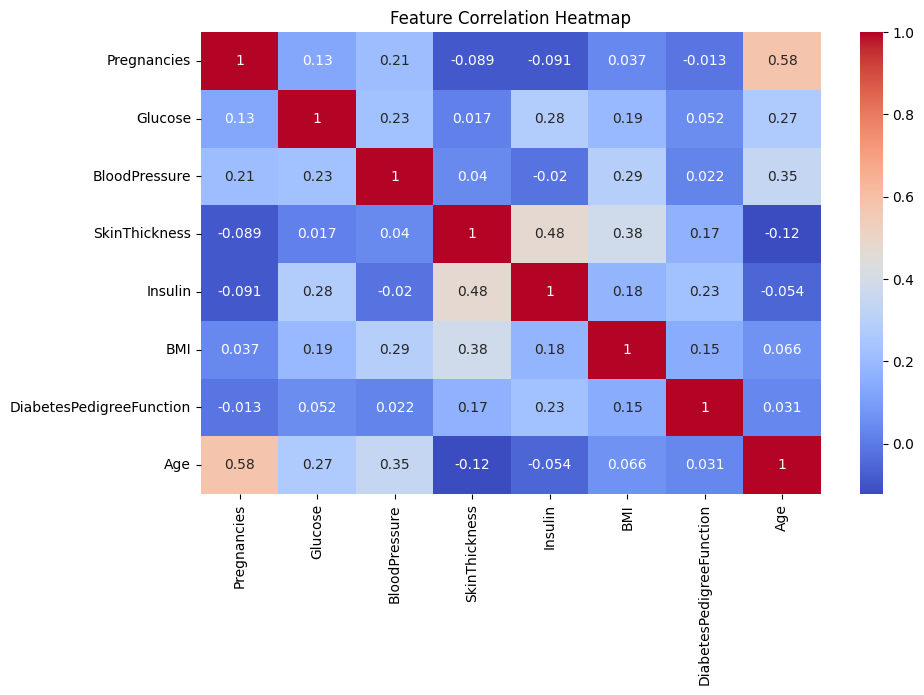

In [16]:
# 2. Feature Selection
# --------------------------------------------

# 2.1 SelectKBest
selector = SelectKBest(score_func=f_classif, k=5)
X_new = selector.fit_transform(X_scaled, y)
selected_features = df_no_outliers.drop('Outcome', axis=1).columns[selector.get_support()]
print("Selected features:", list(selected_features))

# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_no_outliers.drop('Outcome', axis=1).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [17]:
# 3.1 Train-Test Split (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42)

# Justification: 70-30 split balances training data size with a sufficient testing subset

# 3.2 Train Models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN (k=3)": KNeighborsClassifier(n_neighbors=3),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model

In [19]:
# 4. Performance Evaluation
# --------------------------------------------

def evaluate_model(model, X_test, y_test, name): # Added 'name' parameter
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    TPR = tp / (tp + fn)
    FNR = fn / (tp + fn)
    TNR = tn / (tn + fp)
    FPR = fp / (tn + fp)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Changed from model._class.name_ to using the 'name' parameter
    print(f"---- {name} ----")
    print("Confusion Matrix:\n", cm)
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"Recall (TPR): {TPR:.2f}")
    print(f"FNR: {FNR:.2f}")
    print(f"TNR: {TNR:.2f}")
    print(f"FPR: {FPR:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}\n")
    return acc

accuracies = {}
for name, model in trained_models.items():
    print(f"\n=== {name} ===")
    # Pass the model name to the evaluation function
    acc = evaluate_model(model, X_test, y_test, name)
    accuracies[name] = acc


=== Random Forest ===
---- Random Forest ----
Confusion Matrix:
 [[116  22]
 [ 26  27]]
Accuracy: 0.75
Precision: 0.55
Recall (TPR): 0.51
FNR: 0.49
TNR: 0.84
FPR: 0.16
F1 Score: 0.53
ROC AUC: 0.76


=== KNN (k=3) ===
---- KNN (k=3) ----
Confusion Matrix:
 [[111  27]
 [ 28  25]]
Accuracy: 0.71
Precision: 0.48
Recall (TPR): 0.47
FNR: 0.53
TNR: 0.80
FPR: 0.20
F1 Score: 0.48
ROC AUC: 0.68


=== Logistic Regression ===
---- Logistic Regression ----
Confusion Matrix:
 [[119  19]
 [ 32  21]]
Accuracy: 0.73
Precision: 0.53
Recall (TPR): 0.40
FNR: 0.60
TNR: 0.86
FPR: 0.14
F1 Score: 0.45
ROC AUC: 0.77



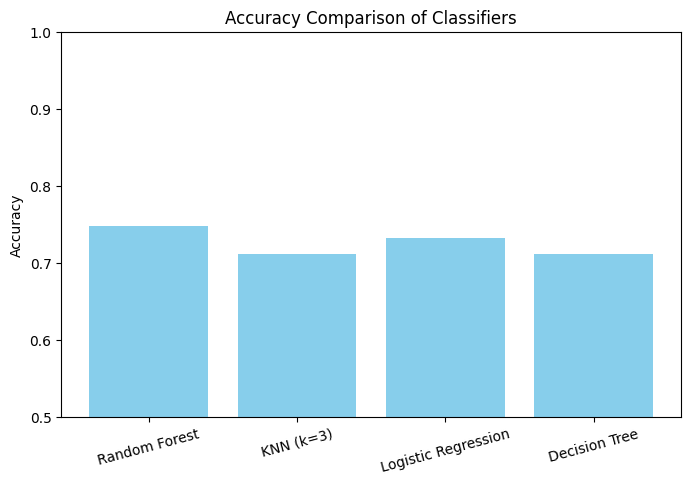

In [20]:
# 5. Visualization
# --------------------------------------------

# 5.1 Accuracy Comparison: Logistic Regression vs Decision Tree
# Train Decision Tree separately
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
acc_dt = accuracy_score(y_test, dt.predict(X_test))
accuracies["Decision Tree"] = acc_dt

# Bar plot
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Classifiers")
plt.xticks(rotation=15)
plt.ylim(0.5, 1)
plt.show()